# Task 4 - Rank drug targets

## Imports

In [60]:
import scanpy as sc
import numpy as np
import anndata as ad
from helical.models.geneformer import Geneformer, GeneformerConfig
import os
import pandas as pd
import seaborn as sns

from collections.abc import Sequence
from typing import Literal
from anndata import AnnData

## Functions

In [3]:
def perturb_genes(
    adata: AnnData,
    target: tuple[str, Sequence[str]],
    factor: tuple[float, Sequence[float]],
    copy: bool = False,
) -> AnnData | None:
    """Perturb selected genes.

    Change the expression of provided genes by a factor and round back to integers.
    Expects raw count data.

    Parameters
    ----------
    adata
        The annotated data matrix.
    target
        Which gene(s) to perturb.
    factor
        Factor for simulated perturbation per provided gene. Must be a positive number.
    copy
        Whether to copy `adata` or modify it inplace.

    Returns
    -------
    Returns `None` if `copy=False`, else returns an `AnnData` object.

    """
    # Sanity checks on inputs
    if isinstance(target, str):
        target = [target]
    if isinstance(factor, float):
        factor = [factor]
        
    if len(target) != len(factor):
        msg = (
            f"the number of provided targets must match the number of provided factors, but {len(target)} and {len(factor)} values were passed, respectively"
        )
        raise ValueError(msg)

    missing_genes = [t for t in target if t not in adata.var_names]
    if missing_genes:
        msg = (
            f"the following provided targets were not found in the index of the provided anndata object: {missing_genes!r}. Example names are {adata.var_names[:3].tolist()}"
        )
        raise ValueError(msg)

    if [f for f in factor if f < 0.]:
        msg = (
            f"some provided factors were smaller than 0. Please only provide positive numbers."
        )
        raise ValueError(msg)

    if len(target) != len(set(target)):
        msg = (
            f"target contains duplicate values."
        )
        raise ValueError(msg)

    # Create copy of adata if requested
    adata = adata.copy() if copy else adata

    # Perturb genes
    perturbed_counts = adata[:, target].X.multiply(factor)
    perturbed_counts = np.round(perturbed_counts)
    adata[:, target].X = perturbed_counts.tocsr()

    return adata if copy else None

## Perturb ALS genes individually

Using the three first discovered definitive ALS genes from https://alsod.ac.uk/:

SOD1 - ENSG00000142168

VAPB - ENSG00000124164

TARDBP - ENSG00000120948

In [23]:
adata_unperturbed = sc.read_h5ad("../data/adata_unperturbed.h5ad")
adata_unperturbed

AnnData object with n_obs × n_vars = 50000 × 36503
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1'
    var: 'Gene', 'Chromosome', 'Biotype', 'ensembl_id'

In [5]:
# Knock-up/down of individual ALS-associated genes in ALS samples
factors = {"up": 2.0, "down":0.5}
for d, f in factors.items()
    for g in ["ENSG00000142168", "ENSG00000124164", "ENSG00000120948"]:
        # Perturb single gene
        adata_ALS_perturb_1[g] = perturb_genes(adata_unperturbed[adata_unperturbed.obs["Condition"]=="ALS"], g, f, copy=True)
        adata_ALS_perturb_1[g].write(f"../data/adata_ALS_perturb_1_{d}_{g}.h5ad", compression="gzip")
    
        # Get Geneformer embedding
        model_config = GeneformerConfig(model_name="gf-12L-95M-i4096", batch_size=10,device="cuda")
        geneformer = Geneformer(configurer=model_config)
        dataset = geneformer.process_data(adata_ALS_perturb_1[g], gene_names="ensembl_id", use_raw_counts=True)
        adata_ALS_perturb_1[g].obsm["X_geneformer"] = geneformer.get_embeddings(dataset)
    
        # Compute neighbors and UMAP
        sc.pp.neighbors(adata_ALS_perturb_1[g], use_rep="X_geneformer")
        sc.tl.umap(adata_ALS_perturb_1[g])
    
        # Convert var index to str to avoid h5py error and write to disk
        adata_ALS_perturb_1[g].var.index = adata_ALS_perturb_1[g].var.index.astype(str)
        adata_ALS_perturb_1[g].write(f"../data/adata_ALS_perturb_1_{d}_{g}_geneformer.h5ad", compression="gzip")

INFO:helical.models.geneformer.model:Model finished initializing.
INFO:helical.models.geneformer.model:'gf-12L-95M-i4096' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:helical.models.geneformer.model:Processing data for Geneformer.
Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28500/28500 [01:49<00:00, 260.67 examples/s]
INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.
INFO:helical.models.geneformer.model:Started getting embeddings:
 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2662/2850 [21:39<01:32,  2.04it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerA

## Compute mean distance to healthy for every perturbation condition

In [43]:
# load single gene perturbation data
adatas = {}
for f in os.listdir("../data/"):
    if f.startswith("adata_ALS_perturb_1_") and f.endswith("geneformer.h5ad"):
        direction = f.split("_")[4]
        gene = f.split("_")[5]
        adata = sc.read_h5ad(f"../data/{f}")
        adata.var.index = adata.var["ensembl_id"]
        adata.obs["pert_direction"] = f.split("_")[4]
        adata.obs["pert_gene"] = f.split("_")[5]
        adata.obs["dataset"] = "_".join(f.split("_")[4:6])
        adatas[f"{gene}_{direction}"] = adata
adata = ad.concat(adatas, index_unique="_")

  utils.warn_names_duplicates("var")

  utils.warn_names_duplicates("var")

  utils.warn_names_duplicates("var")

  utils.warn_names_duplicates("var")

  utils.warn_names_duplicates("var")

  utils.warn_names_duplicates("var")



In [44]:
# preconpute healthy centroids per CellClass in geneformer embedding
adata_unperturbed = sc.read_h5ad("../data/adata_unperturbed_geneformer.h5ad")
healthy_centroids = {
    ct: adata_unperturbed[(adata_unperturbed.obs["Condition"] == "PN") & (adata_unperturbed.obs["CellClass"] == ct)].obsm["X_geneformer"].mean(axis=0)
    for ct in adata_unperturbed.obs["CellClass"].cat.categories
}

  utils.warn_names_duplicates("var")



In [54]:
# compute euclidean distance of every perturbed cell to its matching healthy control celltype cluster centroid
cell_distance_fromPNmean = pd.Series()

for ds in adata.obs["dataset"].unique():
    for ct in adata.obs["CellClass"].cat.categories:
        cell_distance_fromPNmean = pd.concat([
            cell_distance_fromPNmean,
            pd.Series(
                np.linalg.norm(adata[(adata.obs["dataset"] == ds) & (adata.obs["CellClass"] == ct)].obsm["X_geneformer"] - healthy_centroids[ct], axis=1),
                index=adata[(adata.obs["dataset"] == ds) & (adata.obs["CellClass"] == ct)].obs_names)
        ])

adata.obs["cell_distance_fromPNmean"] = cell_distance_fromPNmean.loc[adata.obs_names]

  cell_distance_fromPNmean = pd.concat([



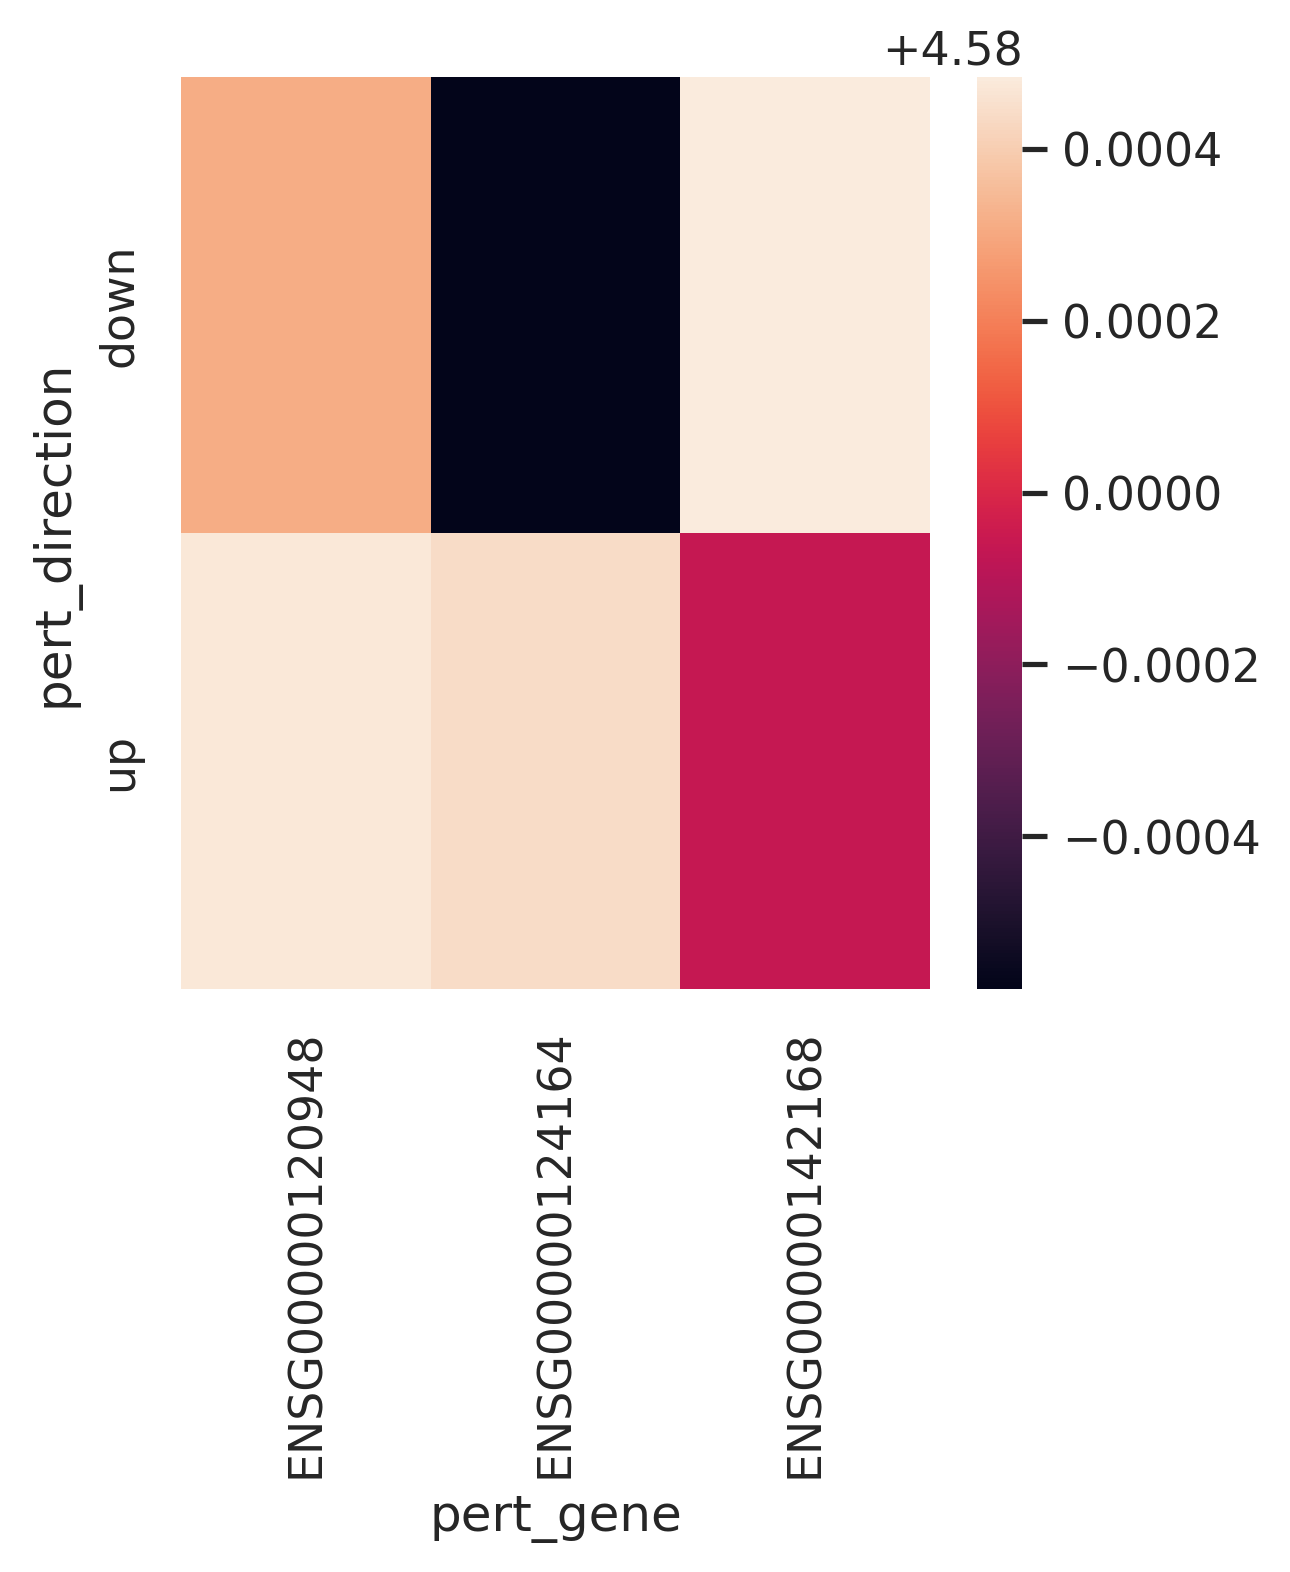

In [82]:
# compute the mean distance over cell types and plot
distance_means = adata.obs.groupby(["pert_direction", "pert_gene", "CellClass"], observed=True)["cell_distance_fromPNmean"].mean()
distance_means = distance_means.groupby(level=[0, 1], observed=True).mean() # take mean over all celltypes
distance_means = distance_means.unstack()

sns.set_theme()
sns.heatmap(distance_means);